<h1 align="center"> Personalized Medicine: Redefining Cancer Treatment</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from time import process_time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable


In [2]:
# Reading Gene and Variation Data
data=pd.read_csv("data/training_variants.csv",index_col='ID')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 3 columns):
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(1), object(2)
memory usage: 103.8+ KB


,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


In [3]:
# Reading Text data
data_text=pd.read_csv('data/training_text.csv',sep='\|\|',engine='python',names=['ID','Text'],skiprows=1,index_col='ID')
print(data_text.info())
data_text.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
Text    3316 non-null object
dtypes: object(1)
memory usage: 51.9+ KB
None


,Text
ID,
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing of text</h3>

In [4]:
# loading stop words from nltk library
stop_words=set(stopwords.words('english'))

def preprocessing(text):
    # replace every special char with space
    text=re.sub('[^a-zA-Z0-9]',' ',text)
     # replace multiple spaces with single space
    text=re.sub('\s+',' ',text)
    # converting all the chars into lower-case.
    text=text.lower()
    string=""
    for word in text.split():
    # if the word is a not a stop word then retain that word from the data
        if word not in stop_words:
            string+=word+' '
    return string

In [5]:
#text processing stage.
start_time=process_time()
data_text['Text']=data_text['Text'].apply(lambda text:preprocessing(text) if type(text)==str else np.NaN)
print('Time taken for preprocessing :',process_time()-start_time)

Time taken for preprocessing : 28.484375


In [6]:
#merging both gene_variations and text data based on ID
df=pd.merge(data,data_text,on='ID',how='left')
df.head()

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,CBL,W802*,2,abstract background non small cell lung cancer...
2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
df[df.isnull().any(axis=1)]

,Gene,Variation,Class,Text
ID,,,,
1109,FANCA,S1088F,1,NaN
1277,ARID5B,Truncating Mutations,1,NaN
1407,FGFR3,K508M,6,NaN
1639,FLT1,Amplification,6,NaN
2755,BRAF,G596C,7,NaN


In [8]:
# If text is null, text='gene variation'
df.loc[df['Text'].isnull(),'Text']=df['Gene']+' '+df['Variation']

In [9]:
df.iloc[1109]

Gene                FANCA
Variation          S1088F
Class                   1
Text         FANCA S1088F
Name: 1109, dtype: object

In [10]:
y=df['Class'].values
# Replace space with '_' in gene and variation features
df['Gene']=df.Gene.str.replace('\s+','_')
df['Variation']=df.Variation.str.replace('\s+','_')

In [11]:
# Split the data into train and test set preserving the ratio of class distribution in the original data set
x_train,x_test,y_train,y_test=train_test_split(df,y,test_size=0.2,stratify=y,random_state=1)
print('Number of point in train data :',x_train.shape[0])
print('Number of point in test data :',x_test.shape[0])

Number of point in train data : 2656
Number of point in test data : 665


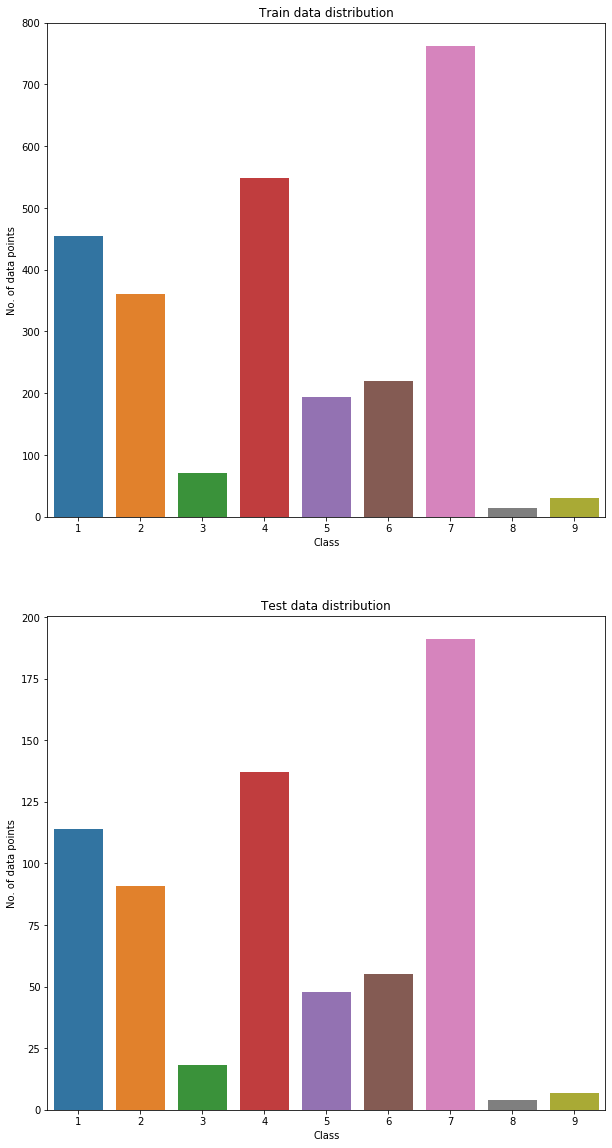

In [12]:
_,axes=plt.subplots(2,1,figsize=(10,20))
train_dist=x_train['Class'].value_counts(sort=False)
test_dist=x_test['Class'].value_counts(sort=False)

sns.barplot(train_dist.index,train_dist.values,ax=axes[0])
axes[0].set_title('Train data distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('No. of data points')

sns.barplot(test_dist.index,test_dist.values,ax=axes[1])
axes[1].set_title('Test data distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('No. of data points')
plt.show()

Classes 8 and 9 have very few data points

In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Test Data using Random Model 2.46684939349935
-------------------- Confusion matrix --------------------


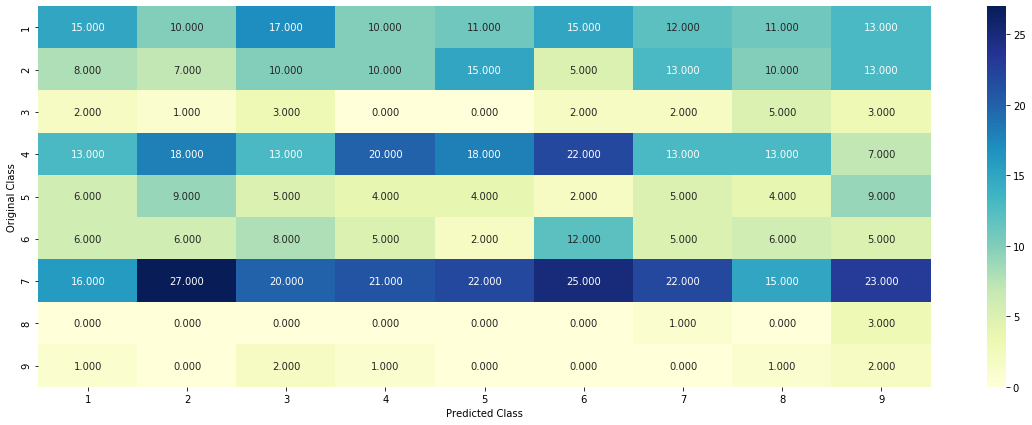

-------------------- Precision matrix (Columm Sum=1) --------------------


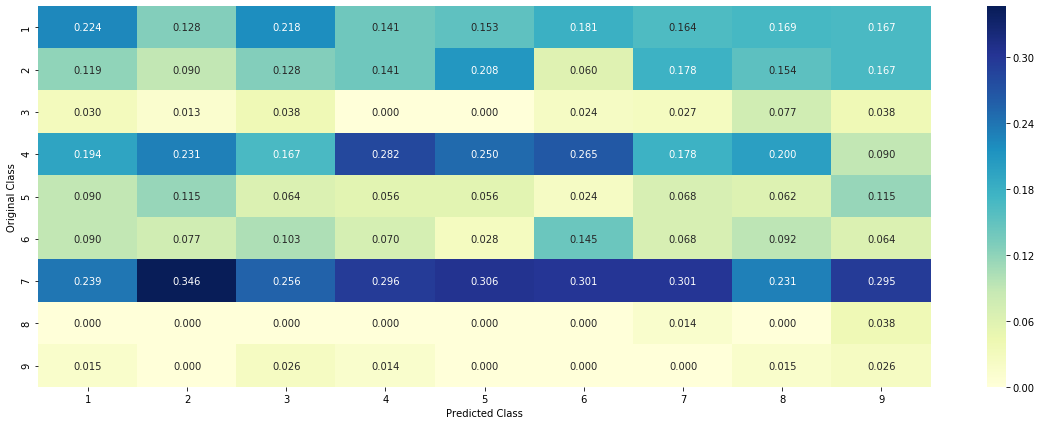

-------------------- Recall matrix (Row sum=1) --------------------


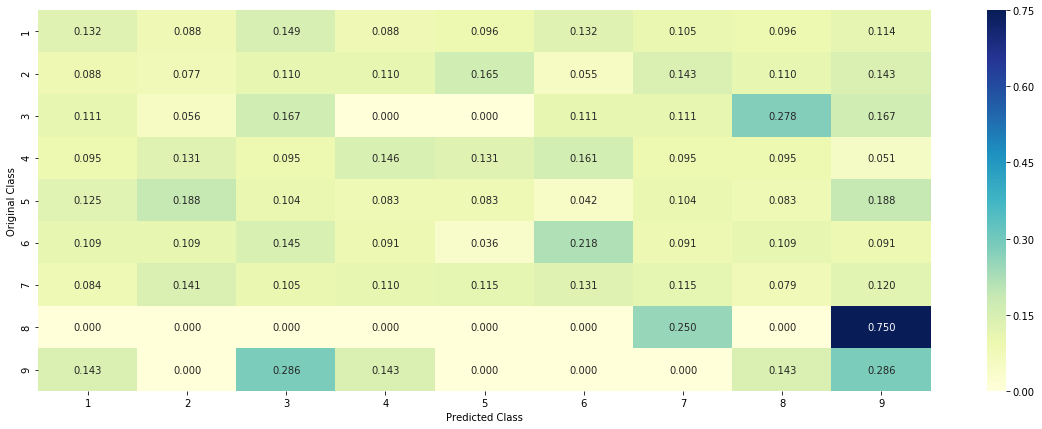

In [14]:
# Prediction using a random model
test_rand=np.zeros((y_test.shape[0],9))

for i in range(test_rand.shape[0]):
    prob=np.random.rand(1,9)
    test_rand[i]=prob/np.sum(prob)
print("Log loss on Test Data using Random Model",log_loss(y_test,test_rand))

rand_y =np.argmax(test_rand, axis=1)
plot_confusion_matrix(y_test,rand_y+1)

In [15]:
# Target encoding with Laplace smoothing.

def target_encoding(alpha,feature,df):
    # value_count will contain the number of time a particular feature occured in whole data
    value_count=x_train[feature].value_counts()
    # feature_dict : Dictionary containing the probability array for each feature
    feature_dict=dict()
    for i,count in value_count.items():
        # arr will contain p(yi==1/Gi) probability of feature belongs to particular class
        # arr is 9 diamensional vector
        arr=[]
        for j in range(1,10):
            # class_count is the number of occurences of the feature in that particular class
            class_count=x_train.loc[(x_train['Class']==j) & (x_train[feature]==i)].shape[0]
            # perform laplace smoothing
            arr.append((class_count+alpha)/(count+9*alpha))
        feature_dict[i]=arr
    
    encoding_list=[]
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to encoding_list
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to encoding_list
    for index,row in df.iterrows():
        if row[feature] in feature_dict:
            encoding_list.append(feature_dict[row[feature]])
        else:
            encoding_list.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return np.array(encoding_list)

Number of Unique Genes : 253
BRCA1     205
TP53      138
EGFR      108
PTEN      104
BRCA2     103
BRAF       80
KIT        75
ERBB2      54
ALK        51
PDGFRA     48
Name: Gene, dtype: int64


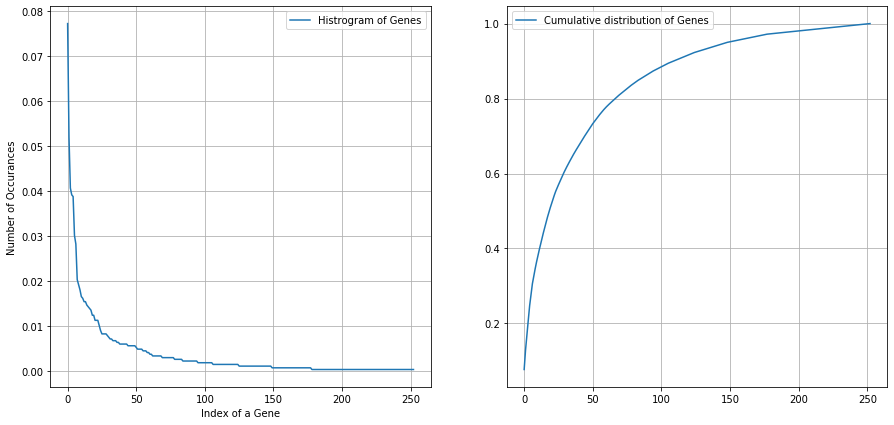

In [16]:
# Analysis of gene feature
unique_genes=x_train['Gene'].value_counts()
print("Number of Unique Genes :",unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))
s=np.sum(unique_genes.values)
hist=unique_genes.values/s
cdf=np.cumsum(hist)
_,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(hist, label="Histrogram of Genes")
axes[0].set_xlabel('Index of a Gene')
axes[0].set_ylabel('Number of Occurances')
axes[0].legend()
axes[0].grid()
axes[1].plot(cdf, label="Cumulative distribution of Genes")
axes[1].legend()
axes[1].grid()
plt.show()

In [17]:
# Target encoding of Gene feature
# alpha is used for laplace smoothing
alpha = 1

gene_target_encoding_train=target_encoding(alpha,'Gene',x_train)
gene_target_encoding_test=target_encoding(alpha,'Gene',x_test)

In [18]:
# One hot encoding of Gene feature.
gene_ohe=OneHotEncoder(dtype=np.int8,handle_unknown='ignore')

gene_onehot_train=gene_ohe.fit_transform(np.reshape(np.array(x_train['Gene']),(-1,1)))
gene_onehot_test=gene_ohe.transform(np.reshape(np.array(x_test['Gene']),(-1,1)))

In [19]:
clf=LogisticRegression(solver='liblinear',multi_class='auto')
grid=GridSearchCV(clf,param_grid={'C':[10**-2,10**-1,1,10,100]},n_jobs=-1,cv=5,return_train_score=True)
grid.fit(gene_onehot_train,y_train)
calib_clf=CalibratedClassifierCV(clf,cv=5)
calib_clf.fit(gene_onehot_train,y_train)
prob=calib_clf.predict_proba(gene_onehot_train)
print("Train log loss using only Gene feature :",log_loss(y_train,prob))
prob=calib_clf.predict_proba(gene_onehot_test)
print("Test log loss using only Gene feature :",log_loss(y_test,prob))

Train log loss using only Gene feature : 1.0470224637211616
Test log loss using only Gene feature : 1.1925567187336874


In [20]:
print('Percentage of data point in Test dataset containing genes not present in Train dataset :',(1-x_test[x_test['Gene'].isin(set(x_train['Gene']))].shape[0]/x_test.shape[0])*100)

Percentage of data point in Test dataset containing genes not present in Train dataset : 1.9548872180451093


Gene feature is stable across Train and Test datasets.

Number of Unique Variations : 2393
Truncating_Mutations    73
Amplification           62
Deletion                54
Fusions                 31
Overexpression           5
G12V                     4
Q61L                     3
T58I                     3
Q61R                     2
G12A                     2
Name: Variation, dtype: int64


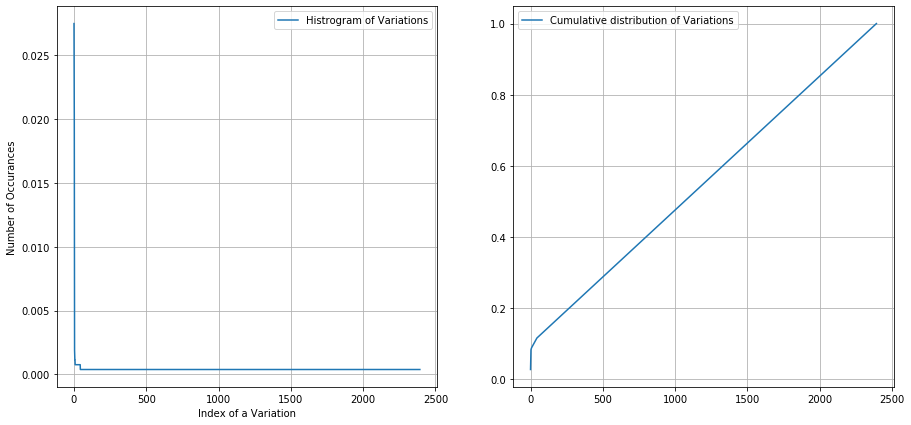

In [21]:
unique_variation=x_train['Variation'].value_counts()
print("Number of Unique Variations :",unique_variation.shape[0])
# the top 10 variations that occured most
print(unique_variation.head(10))
s=np.sum(unique_variation.values)
hist=unique_variation.values/s
cdf=np.cumsum(hist)
_,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(hist, label="Histrogram of Variations")
axes[0].set_xlabel('Index of a Variation')
axes[0].set_ylabel('Number of Occurances')
axes[0].legend()
axes[0].grid()
axes[1].plot(cdf, label="Cumulative distribution of Variations")
axes[1].legend()
axes[1].grid()
plt.show()

In [22]:
# alpha is used for laplace smoothing
alpha=1
# target encoding of variation feature
variation_target_encoding_train=target_encoding(alpha,'Variation',x_train)
variation_target_encoding_test=target_encoding(alpha,'Variation',x_test)

In [23]:
# one-hot encoding of variation feature.
variation_ohe=OneHotEncoder(dtype=np.int8,handle_unknown='ignore')

variation_onehot_train=variation_ohe.fit_transform(np.reshape(np.array(x_train['Variation']),(-1,1)))
variation_onehot_test=variation_ohe.transform(np.reshape(np.array(x_test['Variation']),(-1,1)))

In [24]:
clf=LogisticRegression(solver='liblinear',multi_class='auto')
grid=GridSearchCV(clf,param_grid={'C':[10**-2,10**-1,1,10,100]},n_jobs=-1,cv=5,return_train_score=True)
grid.fit(variation_onehot_train,y_train)
calib_clf=CalibratedClassifierCV(clf,cv=5)
calib_clf.fit(variation_onehot_train,y_train)
prob=calib_clf.predict_proba(variation_onehot_train)
print("Train log loss using only Variation feature :",log_loss(y_train,prob))
prob=calib_clf.predict_proba(variation_onehot_test)
print("Test log loss using only Variation feature :",log_loss(y_test,prob))

Train log loss using only Variation feature : 1.071438358475621
Test log loss using only Variation feature : 1.7342793297747374


In [25]:
print('Percentage of data point in Test dataset containing variations not present in Train dataset :',(1-x_test[x_test['Variation'].isin(set(x_train['Variation']))].shape[0]/x_test.shape[0])*100)

Percentage of data point in Test dataset containing variations not present in Train dataset : 90.67669172932331


Variation feature is not stable across Train and Test datasets but it reduces log loss significantly

In [26]:
# TF-IDF
tfidf=TfidfVectorizer(max_features=2000,ngram_range=(1,3))
text_feature_train=tfidf.fit_transform(x_train['Text'])
text_feature_test=tfidf.transform(x_test['Text'])

In [27]:
clf=LogisticRegression(solver='liblinear',multi_class='auto')
grid=GridSearchCV(clf,param_grid={'C':[10**-2,10**-1,1,10,100]},n_jobs=-1,cv=5,return_train_score=True)
grid.fit(text_feature_train,y_train)
calib_clf=CalibratedClassifierCV(clf,cv=5)
calib_clf.fit(text_feature_train,y_train)
prob=calib_clf.predict_proba(text_feature_train)
print("Train log loss using only Text feature :",log_loss(y_train,prob))
prob=calib_clf.predict_proba(text_feature_test)
print("Test log loss using only Text feature :",log_loss(y_test,prob))

Train log loss using only Text feature : 0.9399608613647741
Test log loss using only Text feature : 1.1187739123519038


Text feature seems to be stable accross Train and Test datasets as the difference between log loss of train and test set is small

In [28]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3,max_features=1000)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(tfidf.get_feature_names()) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")

99.5 % of word of test data appeared in train data


In [29]:
# Stacking gene,variation and text features
train_gene_var_onehotCoding = hstack((gene_onehot_train,variation_onehot_train))
test_gene_var_onehotCoding = hstack((gene_onehot_test,variation_onehot_test))

x_train_onehot = hstack((train_gene_var_onehotCoding, text_feature_train)).tocsr()
x_test_onehot = hstack((test_gene_var_onehotCoding, text_feature_test)).tocsr()

scaler=StandardScaler(with_mean=False)
x_train_onehot=scaler.fit_transform(x_train_onehot)
x_test_onehot=scaler.transform(x_test_onehot)

train_gene_var_targetencoding = np.hstack((gene_target_encoding_train,variation_target_encoding_train))
test_gene_var_targetencoding = np.hstack((gene_target_encoding_test,variation_target_encoding_test))

x_train_target_encoding = hstack((train_gene_var_targetencoding, text_feature_train)).tocsr()
x_test_target_encoding = hstack((test_gene_var_targetencoding, text_feature_test)).tocsr()

print("Number of features in Onehot encoding :",x_train_onehot.shape[1])
print("Number of features in Target encoding :",x_train_target_encoding.shape[1])


Number of features in Onehot encoding : 4646
Number of features in Target encoding : 2018


In [30]:
#Function to print train and test scores and confusion matrix
comparison=[]

def display_score(clf,clf_name,onehot):
    if onehot:
        prob_train=clf.predict_proba(x_train_onehot)
        y_pred_train=clf.predict(x_train_onehot)
    else:
        prob_train=clf.predict_proba(x_train_target_encoding)
        y_pred_train=clf.predict(x_train_target_encoding)
    
    print("Train log loss :",log_loss(y_train,prob_train))
    if onehot:
        prob_test=clf.predict_proba(x_test_onehot)
        y_pred_test=clf.predict(x_test_onehot)
    else:
        prob_test=clf.predict_proba(x_test_target_encoding)
        y_pred_test=clf.predict(x_test_target_encoding)
    print("Test log loss :",log_loss(y_test,prob_test))
    print("Mis-classified points in Test dataset :", np.count_nonzero((y_pred_test- y_test))/y_test.shape[0])
    comparison.append([clf_name,np.round(log_loss(y_train,prob_train),4),np.round(log_loss(y_test,prob_test),4),np.round(np.count_nonzero((y_pred_test- y_test))/y_test.shape[0],4)])
    plot_confusion_matrix(y_test, np.argmax(prob_test,axis=1)+1)

Train log loss : 0.9208658719349285
Test log loss : 1.464257001259913
Mis-classified points in Test dataset : 0.45112781954887216
-------------------- Confusion matrix --------------------


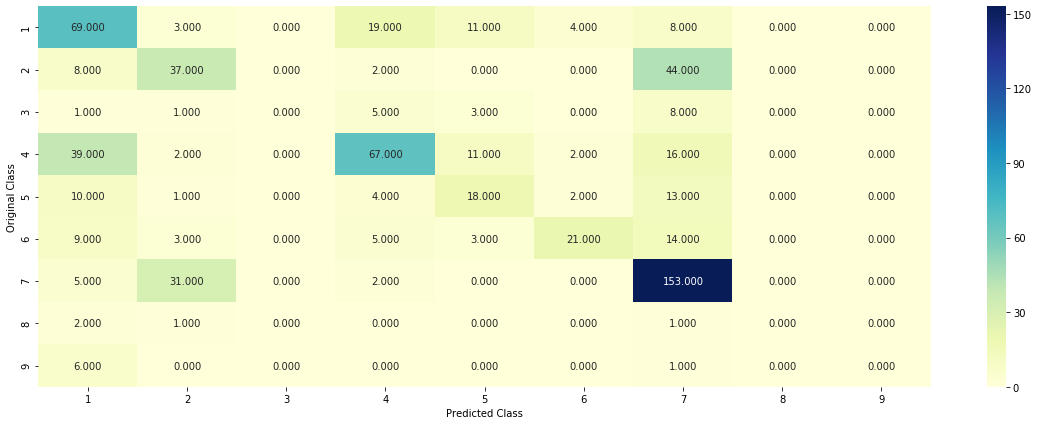

-------------------- Precision matrix (Columm Sum=1) --------------------


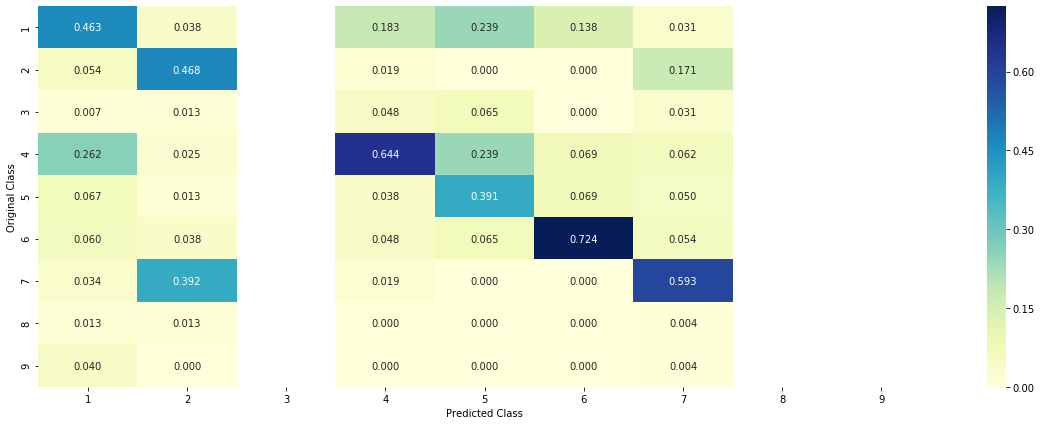

-------------------- Recall matrix (Row sum=1) --------------------


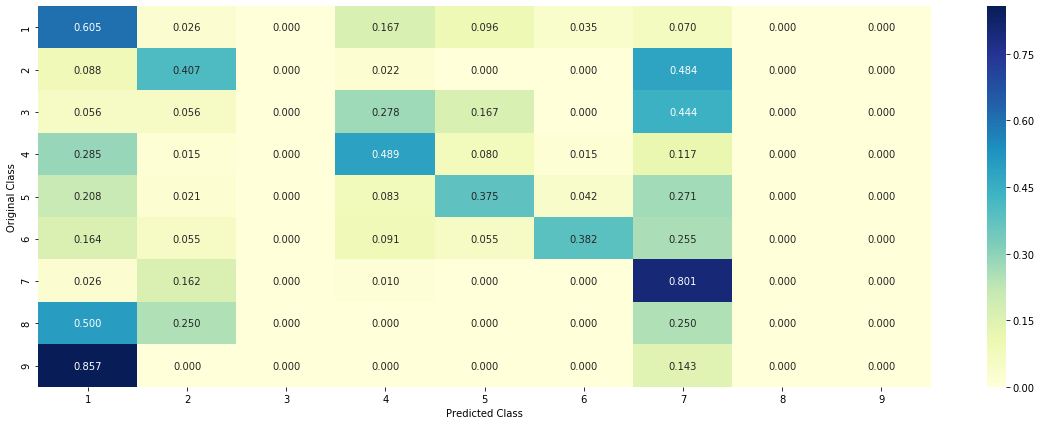

In [31]:
# Naive Bayes
params = {'alpha':[0.0001, 0.001, 0.1, 1, 10, 100]}
clf=MultinomialNB()
grid=GridSearchCV(clf,param_grid=params,n_jobs=-1,cv=5,return_train_score=True,scoring='neg_log_loss')
grid.fit(x_train_onehot,y_train)
# Platt scaling
calib_clf=CalibratedClassifierCV(grid,cv=5)
calib_clf.fit(x_train_onehot,y_train)
display_score(calib_clf,'Naive Bayes',1)


Train log loss : 0.4096344565783662
Test log loss : 1.0438772602628377
Mis-classified points in Test dataset : 0.35037593984962406
-------------------- Confusion matrix --------------------


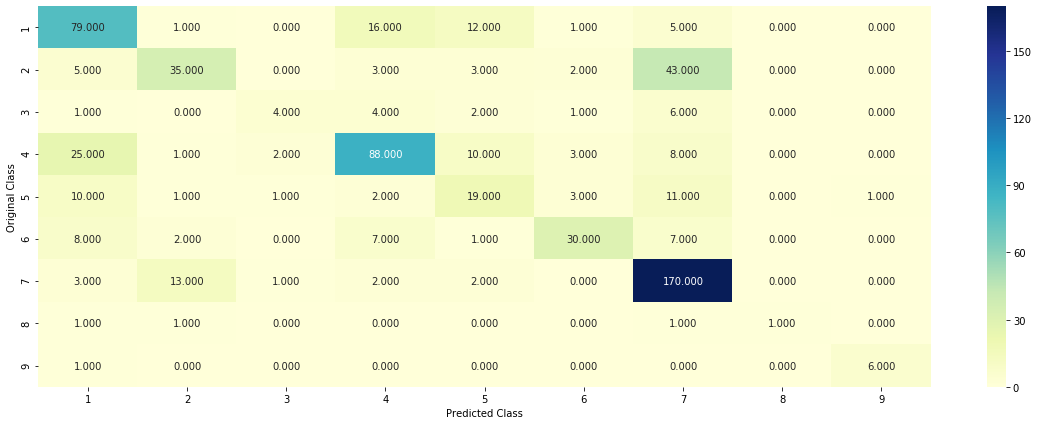

-------------------- Precision matrix (Columm Sum=1) --------------------


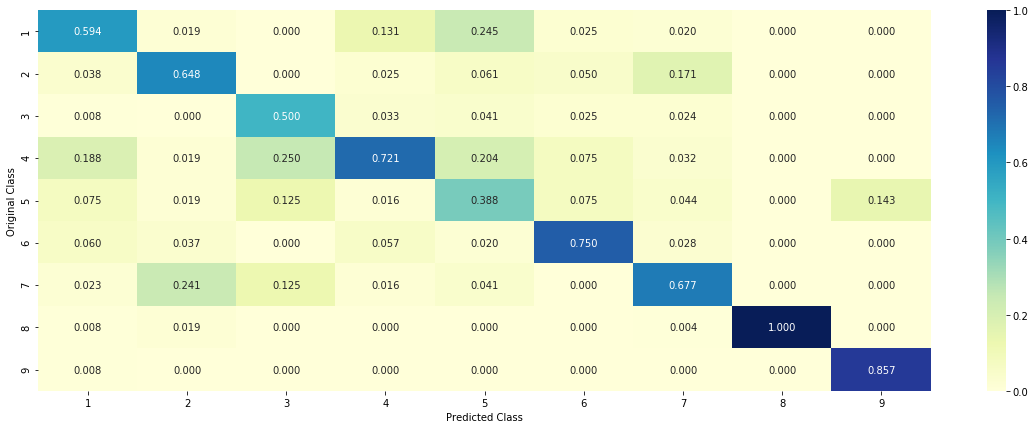

-------------------- Recall matrix (Row sum=1) --------------------


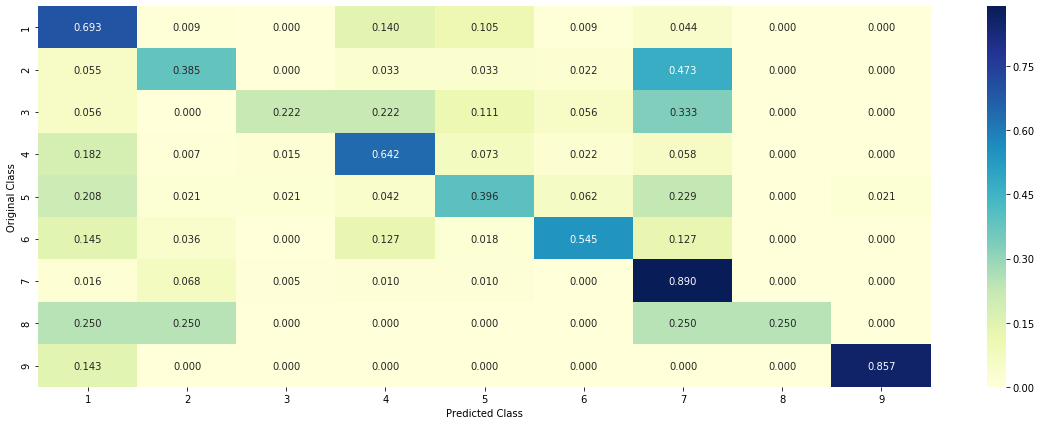

In [32]:
# Logistic regression
params={'C' : [0.001,0.01,0.1]}
clf=LogisticRegression(class_weight='balanced',random_state=0,solver='saga',multi_class='multinomial',n_jobs=-1)
grid=GridSearchCV(clf,param_grid=params,n_jobs=-1,cv=5,return_train_score=True,scoring='neg_log_loss')
grid.fit(x_train_onehot,y_train)
# Platt scaling
calib_clf=CalibratedClassifierCV(grid)
calib_clf.fit(x_train_onehot,y_train)
display_score(calib_clf,'Logistic Regression',1)

Train log loss : 0.30322743102630006
Test log loss : 1.108784001172384
Mis-classified points in Test dataset : 0.37593984962406013
-------------------- Confusion matrix --------------------


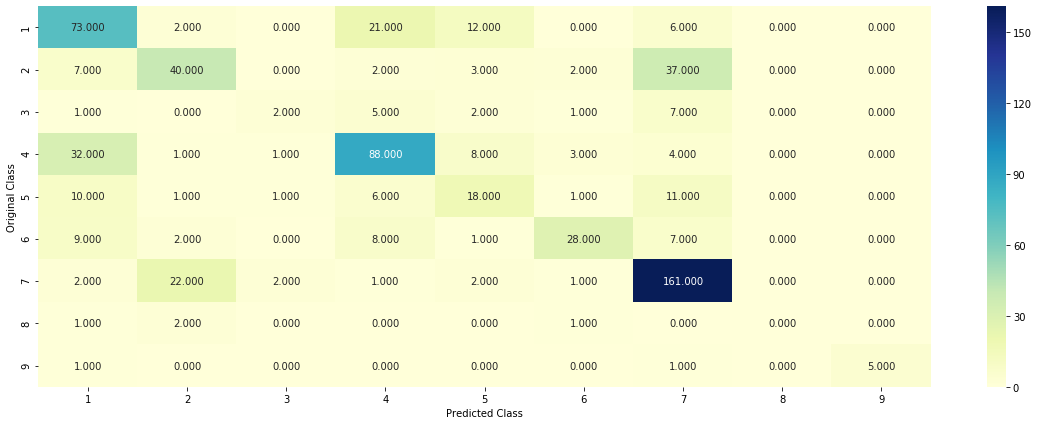

-------------------- Precision matrix (Columm Sum=1) --------------------


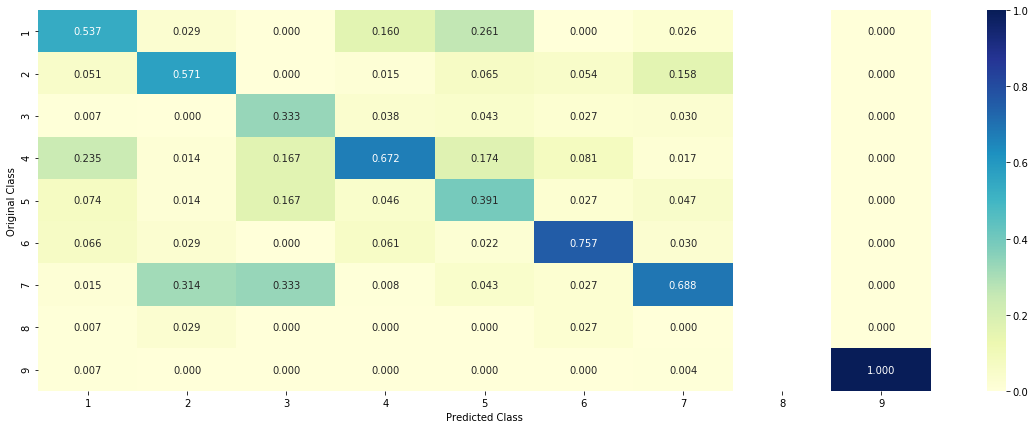

-------------------- Recall matrix (Row sum=1) --------------------


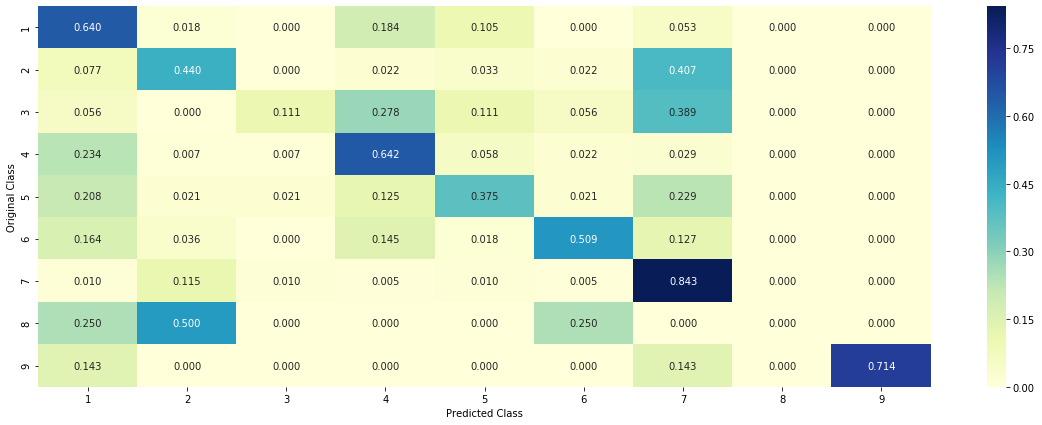

In [33]:
# Linear Support Vector Machine
clf=LinearSVC(loss='hinge',class_weight='balanced',random_state=0)
clf.fit(x_train_onehot,y_train)
# Platt scaling
calib_clf=CalibratedClassifierCV(clf)
calib_clf.fit(x_train_onehot,y_train)
display_score(calib_clf,'Linear SVM',1)

Train log loss : 0.0749196900776969
Test log loss : 0.9234034322015003
Mis-classified points in Test dataset : 0.3218045112781955
-------------------- Confusion matrix --------------------


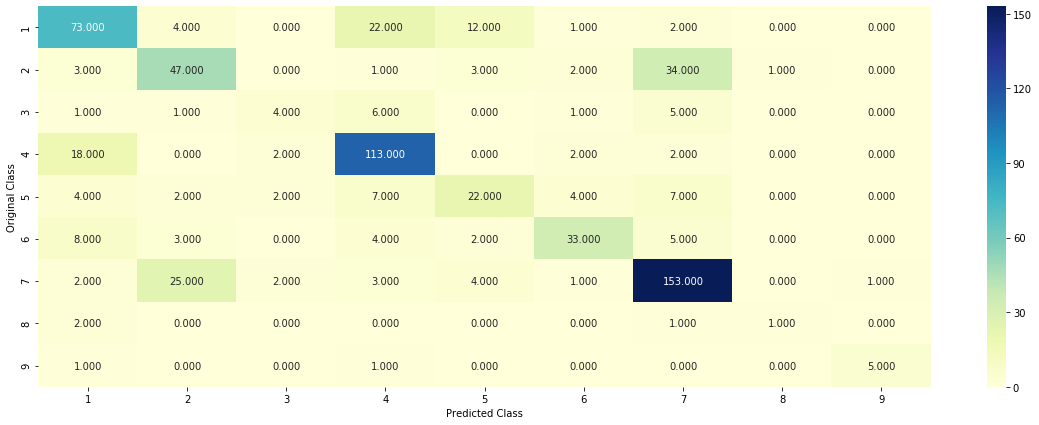

-------------------- Precision matrix (Columm Sum=1) --------------------


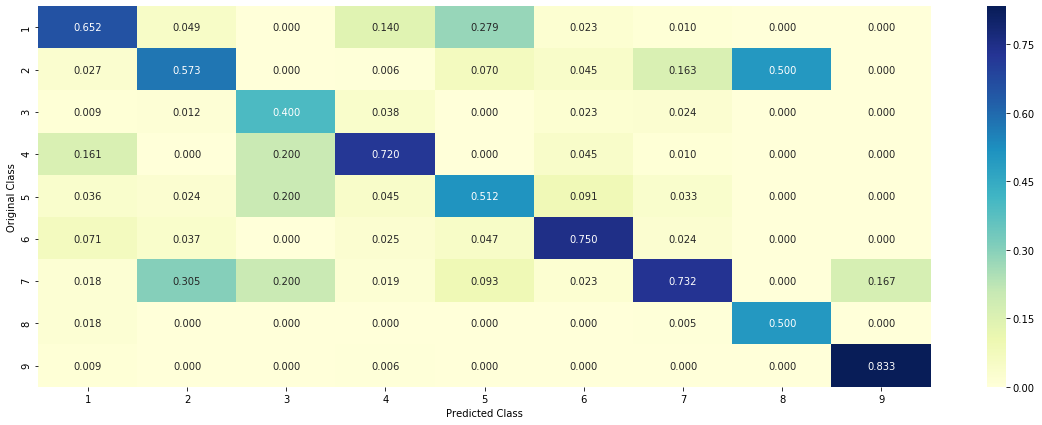

-------------------- Recall matrix (Row sum=1) --------------------


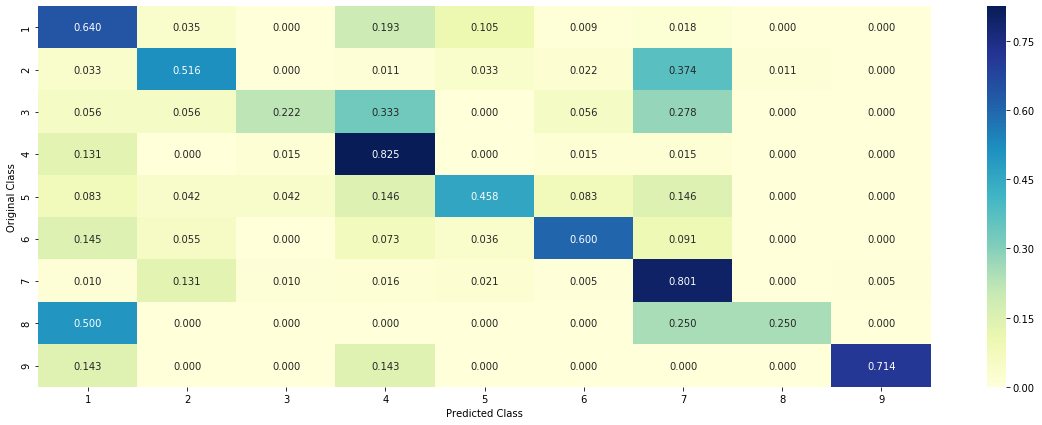

In [34]:
# Random Forest Classifier
params={'n_estimators':[100,500]}
clf=RandomForestClassifier(n_jobs=-1,random_state=0,class_weight='balanced')
grid=GridSearchCV(clf,param_grid=params,n_jobs=-1,cv=5,return_train_score=True,scoring='neg_log_loss')
grid.fit(x_train_target_encoding,y_train)
# Platt scaling
calib_clf=CalibratedClassifierCV(grid)
calib_clf.fit(x_train_target_encoding,y_train)
display_score(calib_clf,'Random Forest',0)

In [35]:
# Results 
results=PrettyTable()
results.field_names = ["Classification model", "Train log loss", "Test log loss", "Misclassification"]
for i in comparison:
    results.add_row(i)
print(results)

+----------------------+----------------+---------------+-------------------+
| Classification model | Train log loss | Test log loss | Misclassification |
+----------------------+----------------+---------------+-------------------+
|     Naive Bayes      |     0.9209     |     1.4643    |       0.4511      |
| Logistic Regression  |     0.4096     |     1.0439    |       0.3504      |
|      Linear SVM      |     0.3032     |     1.1088    |       0.3759      |
|    Random Forest     |     0.0749     |     0.9234    |       0.3218      |
+----------------------+----------------+---------------+-------------------+


Random forest has the best performance.

In [36]:
#Feature importance
data_index=1
top_features=100
print("Predicted Class :",calib_clf.predict(x_train_target_encoding[data_index])[0])
print("Actual Class :",y_train[data_index])
print("Probalities ",np.around(calib_clf.predict_proba(x_train_target_encoding[data_index])[0],4))
indices=np.argsort(-grid.best_estimator_.feature_importances_)[:top_features]
tfidf_features_names=tfidf.get_feature_names()
print("-"*50)
counter=0
for idx,i in enumerate(indices):
    if i>17 and tfidf_features_names[i-17] in x_train.iloc[data_index]['Text']:
        counter+=1
        print(idx+1,"Text feature [",tfidf_features_names[i-17],"] present in query point")
print()
print("Out of the top",top_features,"features,",counter,"are present in query point")

Predicted Class : 5
Actual Class : 5
Probalities  [0.0625 0.0023 0.0077 0.0762 0.7702 0.0736 0.0012 0.0027 0.0036]
--------------------------------------------------
21 Text feature [ variation ] present in query point
29 Text feature [ cells expressing ] present in query point
30 Text feature [ mutant p53 ] present in query point
48 Text feature [ samples ] present in query point
49 Text feature [ never ] present in query point
50 Text feature [ surface ] present in query point
59 Text feature [ assess ] present in query point
61 Text feature [ contains ] present in query point
64 Text feature [ indicated ] present in query point
65 Text feature [ activation ] present in query point
66 Text feature [ 17 ] present in query point
68 Text feature [ although ] present in query point
71 Text feature [ red ] present in query point
74 Text feature [ variants ] present in query point
76 Text feature [ experiment ] present in query point
77 Text feature [ conformation ] present in query point


In [37]:
# Reading Gene and Variation Data
test_variants=pd.read_csv("data/stage2_test_variants.csv",index_col='ID',)
test_variants.info()
test_variants.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 1 to 986
Data columns (total 2 columns):
Gene         986 non-null object
Variation    986 non-null object
dtypes: object(2)
memory usage: 23.1+ KB


,Gene,Variation
ID,,
1,CHEK2,H371Y
2,AXIN2,Truncating Mutations
3,WNT4,E216G
4,SUCLA2,G118R
5,BRAF,T599insTT


In [38]:
# Reading Text data
test_text= pd.read_csv('data/stage2_test_text.csv', sep="\|\|", engine='python',names=['ID','Text'], header=None, skiprows=1,index_col='ID')
print(test_text.info())
test_text.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 1 to 986
Data columns (total 1 columns):
Text    986 non-null object
dtypes: object(1)
memory usage: 15.4+ KB
None


,Text
ID,
1,The incidence of breast cancer is increasing i...
2,An unselected series of 310 colorectal carcino...
3,Mycosis fungoides and SÃ©zary syndrome are pri...
4,Regulated progression through the cell cycle ...
5,Pilocytic astrocytoma (PA) is emerging as a tu...


In [39]:
submission=pd.read_csv("data/stage2_sample_submission.csv")
submission.info()
submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 10 columns):
ID        986 non-null int64
class1    986 non-null int64
class2    986 non-null int64
class3    986 non-null int64
class4    986 non-null int64
class5    986 non-null int64
class6    986 non-null int64
class7    986 non-null int64
class8    986 non-null int64
class9    986 non-null int64
dtypes: int64(10)
memory usage: 77.2 KB


,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0


In [40]:
test_text['Text']=test_text['Text'].apply(lambda text:preprocessing(text) if type(text)==str else np.NaN)


In [41]:
df=pd.merge(data,data_text,on='ID',how='left')
print(df.head())
df.loc[df['Text'].isnull(),'Text']=df['Gene']+' '+df['Variation']
df['Gene']=df.Gene.str.replace('\s+','_')
df['Variation']=df.Variation.str.replace('\s+','_')

      Gene             Variation  Class  \
ID                                        
0   FAM58A  Truncating Mutations      1   
1      CBL                 W802*      2   
2      CBL                 Q249E      2   
3      CBL                 N454D      3   
4      CBL                 L399V      4   

                                                 Text  
ID                                                     
0   cyclin dependent kinases cdks regulate variety...  
1   abstract background non small cell lung cancer...  
2   abstract background non small cell lung cancer...  
3   recent evidence demonstrated acquired uniparen...  
4   oncogenic mutations monomeric casitas b lineag...  


In [42]:
gene_encode=target_encoding(alpha,'Gene',df)
variation_encode=target_encoding(alpha,'Variation',df)
text_encode=tfidf.transform(df['Text'])
gene_var = np.hstack((gene_encode,variation_encode))
gene_var_text = hstack((gene_var, text_encode)).tocsr()
y_pred=calib_clf.predict_proba(gene_var_text)
y_pred_df=pd.DataFrame(y_pred) 
y_pred_df.rename(columns={0:'class1',1:'class2',2:'class3',3:'class4',4:'class5',5:'class6',6:'class7',7:'class8',8:'class9'}, 
                 inplace=True)
submission['class1']=y_pred_df['class1']
for i in y_pred_df.columns:
    submission[i]=y_pred_df[i]
submission.head()


,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.932705,0.004529,0.007359,0.020403,0.009854,0.012891,0.005286,0.003316,0.003657
1,2,0.010334,0.876590,0.007965,0.037251,0.012179,0.042994,0.006112,0.002681,0.003893
2,3,0.022149,0.734795,0.009514,0.108172,0.016487,0.083198,0.017980,0.003004,0.004701
3,4,0.004942,0.003277,0.712582,0.250811,0.008886,0.012069,0.001645,0.002469,0.003319
4,5,0.002605,0.001974,0.006293,0.946429,0.026319,0.009945,0.000986,0.002317,0.003133


In [43]:
submission.to_csv('submission.csv',sep=',',header=True,index=None)